# 1. Set Up

In [23]:
# !spack find -lvp tfel
# !echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [24]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc
    
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))

# 2. Simulation Parameters

In [25]:
#in MPa
def initialize_parameters(custom_mesh_filepath: str = None, soil_model: cm.PropertyTypeEnum = cm.PropertyTypeEnum.le, **kwargs) -> cm.AttrDict:
    params = cm.AttrDict()
    setattr(params, "custom_mesh_filepath", custom_mesh_filepath)
    setattr(params, "soil_model", soil_model)
    for key,value in kwargs.items():
        setattr(params, key, value)
    params.interface = False
    params.pile_manager = cm.PileManager(x=0, y=0, z=0, dx=0, dy=0, R=1, r=0.975,
                                         stickup_height = 10,
                                         embedded_depth = -10.5,
                                preferred_model= cm.PropertyTypeEnum.le,
                                props = {
                                    cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.3),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 10),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.3, phi=np.radians(15), c=10, v=np.radians(15)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    
    # params.interface_manager = cm.InterfaceManager(
    #     preferred_model = cm.PropertyTypeEnum.vM,
    #     props = {
    #         cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
    #         cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49,HardeningSlope = 5000, YieldStress = 20),
    #         cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.49, phi=np.radians(0.05), c=0, v=np.radians(0.05)),
    #         },
    #         )
    
    #=======================================================
    #=======================================================
    #=======================================================
    #if the soil domain is a cuboid
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )
    #if the soil domain is a half cylinder
    params.cylinder_manager = cm.CylinderManager(
        x=0, 
        y=0, 
        z=0, 
        dx=0, 
        dy=0, 
        r=80,
        pile_R = params.pile_manager.R,
        pile_r = params.pile_manager.r,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        mesh_radial_progression = 1.3,
        mesh_radial_divisions = 10,
    )
    #=======================================================
    #=======================================================
    #=======================================================
    
    def custom_generate_physical_groups(params) -> list[cm.PhysicalGroup]:
        physical_group_list = [
            cm.PhysicalGroup(
                meshnet_id=1,
                name="MFRONT_MAT_1",
                preferred_model=params.cylinder_manager.layers[0].preferred_model,
                props=params.cylinder_manager.layers[0].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=2,
                name="MFRONT_MAT_2",
                preferred_model=params.cylinder_manager.layers[1].preferred_model,
                props=params.cylinder_manager.layers[1].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=3,
                name="MFRONT_MAT_3",
                preferred_model=params.cylinder_manager.layers[2].preferred_model,
                props=params.cylinder_manager.layers[2].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=4,
                name="MFRONT_MAT_4",
                preferred_model=params.cylinder_manager.layers[3].preferred_model,
                props=params.cylinder_manager.layers[3].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=5,
                name="MFRONT_MAT_5",
                preferred_model=params.pile_manager.preferred_model,
                props=params.pile_manager.props,
                ),
        ]
        return physical_group_list
    
    if getattr(params, "custom_mesh_filepath", False):
        try:
            params.custom_generate_physical_groups = custom_generate_physical_groups
        except NameError as e:
            raise NameError("Must provided the custom callback 'custom_generate_physical_groups' to inject attributes to the main commmand.")
   
    params.nproc = 8 # number of processors/cores used
    params.dim = 3
    
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"
    params.ffmpeg_path = '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg'
    params.preset_dir = '/mofem_install/jupyter/thomas/mfront_example_test/src/presets'
    
    return params

In [26]:
def postprocessing(params):
    original_pythonpath = os.environ.get("PYTHONPATH", "")
    os.environ["PYTHONPATH"] = ""

    def run_command(command):
        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        for line in iter(process.stdout.readline, ''):
            print(line, end='')  # Print to console
        process.stdout.close()
        process.wait()
        return process.returncode
    
    @ut.track_time("PULLING A SELECTED POINT OVER TIME WITH pvpython")
    def point_to_csv(params, point: cm.Point):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/gauss_point_to_time_csv.py" if params.save_gauss == 1 else "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/point_to_time_csv.py",
            params.vtk_gauss_dir if params.save_gauss == 1 else params.vtk_dir,
            # params.vtk_dir,
            point.point_against_time_csv_filepath(params),
            *point.flat(),
        ]
        # Run the command using subprocess
        run_command(command)
        
    @ut.track_time("PULLING MULTIPLE SELECTED POINTS OVER TIME WITH pvpython")
    def multiple_points_to_csv(params, points_of_interest: list[cm.Point]):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/gauss_multiple_points_to_time_csv.py" if params.save_gauss == 1 else "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/multiple_points_to_time_csv.py",
            params.vtk_gauss_dir if params.save_gauss == 1 else params.vtk_dir,
            # params.vtk_dir,
            str(len(points_of_interest)),
        ]
        for point in points_of_interest:
            command.extend(point.flat())
            command.append(point.point_against_time_csv_filepath(params))
        # Run the command using subprocess
        run_command(command)
        
    @ut.track_time("PULLING A SELECTED LINE OVER DEPTH AT THE FINAL TIMESTEP WITH pvpython")
    def line_to_csv(params, line: cm.Line):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/gauss_line_to_depth_csv.py" if params.save_gauss == 1 else "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/line_to_depth_csv.py",
            params.vtk_gauss_dir if params.save_gauss == 1 else params.vtk_dir,
            # params.vtk_dir,
            line.line_against_depth_csv_filepath(params),
            *line.pt1.flat(),
            *line.pt2.flat(),
        ]
        # Run the command using subprocess
        run_command(command)


    @ut.track_time("PLOTTING COLOR CONTOUR MAP WITH pvpython")
    def contours(params):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/contours.py",
            params.vtk_gauss_dir if params.save_gauss == 1 else params.vtk_dir,
            params.vtk_dir,
            params.graph_dir,
            params.preset_dir,
        ]
        # Run the command using subprocess
        run_command(command)

    

    @ut.track_time("ANIMATING OVER TIME WITH pvpython")
    def animate(params, color_min, color_max):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/pile_animate.py",
            params.vtk_dir,
            params.strain_animation_filepath_png,
            str(color_min),
            str(color_max),
        ]
        # Run the command using subprocess
        try:
            process = subprocess.run(command, check=True, capture_output=True)
            create_mp4_from_png_sequence(params.strain_animation_filepath_png_ffmpeg_regex, params.strain_animation_filepath_mp4, framerate=40)
            
        except subprocess.CalledProcessError as e:
            print("An error occurred:", e.stderr.decode())
        finally:
        # Restore the original PYTHONPATH
            os.environ["PYTHONPATH"] = original_pythonpath

    #Stitch together animations
    @ut.track_time("STITCHING .pngs TOGETHER with ffmpeg")
    def create_mp4_from_png_sequence(animation_filepath_png_ffmpeg_regex, animation_filepath_mp4, framerate=40):
        # Build the ffmpeg command
        ffmpeg_command = [
            params.ffmpeg_path,
            '-framerate', str(framerate),  # Set input framerate
            '-y',
            '-i', animation_filepath_png_ffmpeg_regex,  # Input image sequence (with regex pattern)
            '-c:v', 'libx264',  # Set video codec to libx264
            '-pix_fmt', 'yuv420p',  # Set pixel format for compatibility
            '-loglevel', 'warning',
            animation_filepath_mp4  # Output .mp4 file
        ]

        # Run the ffmpeg command as a subprocess
        try:
            subprocess.run(ffmpeg_command, check=True, capture_output=True)
            print(f"MP4 video created successfully: {animation_filepath_mp4}")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred during ffmpeg execution: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    try:
        # for point in points_of_interest:
            # point_to_csv(params, point)
        multiple_points_to_csv(params, params.points_of_interest)
        # line_to_csv(params, params.line_of_interest)
        # contours(params)
        # df = pd.read_csv(params.points_of_interest[1].point_against_time_csv_filepath(params))
        # strain_magnitude = np.array(df['avg(STRAIN (Magnitude))'])
        # color_max = strain_magnitude.max()
        # color_min = strain_magnitude.min()
        # animate(params, color_min, color_max)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
        # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath
        
    
   

In [27]:
def plot_all_and_auxiliary_saves(params):
    # if params.save_gauss == 1:
    #     pass
    # else:
    #     df = pd.read_csv(params.line_of_interest.line_against_depth_csv_filepath(params))
    #     df = df.dropna()
    #     x = np.array(df['Points:0'])
    #     y = np.array(df['Points:1'])
    #     z = np.array(df['Points:2'])
    #     disp_x = np.array(df['DISPLACEMENT:0'])
    #     disp_y = np.array(df['DISPLACEMENT:1'])
    #     disp_z = np.array(df['DISPLACEMENT:2'])
        
    #     e_xx = np.array(df['STRAIN:0'])
    #     e_xy = np.array(df['STRAIN:1'])
    #     e_xz = np.array(df['STRAIN:2'])
    #     e_yy = np.array(df['STRAIN:4'])
    #     e_yz = np.array(df['STRAIN:5'])
    #     e_zz = np.array(df['STRAIN:8'])
        
    #     sig_xx = np.array(df['STRESS:0'])
    #     sig_xy = np.array(df['STRESS:1'])
    #     sig_xz = np.array(df['STRESS:2'])
    #     sig_yy = np.array(df['STRESS:4'])
    #     sig_yz = np.array(df['STRESS:5'])
    #     sig_zz = np.array(df['STRESS:8'])
        
    #     sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
    #     p = calc.calculate_p(sig_1, sig_2, sig_3)
    #     J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
    #     J  = np.sqrt(J_2)
    #     tau_oct = np.sqrt(2 * J_2)
    #     sig_eq = np.sqrt(3 * J_2)
    #     e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)
    #     graph_dir = params.line_of_interest.graph_dir(params)
    #     if params.save_gauss == 1:
    #         pass
    #     else:
    #         plotting.plot_x_ys(disp_x, [z], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Depth [m]', title='Depth vs $\mu_x$', save_as = f"{graph_dir}/401_z_ux.png")

    # for point in params.points_of_interest:
    #     graph_dir = point.graph_dir(params)
    #     df = pd.read_csv(point.point_against_time_csv_filepath(params))
    #     if params.save_gauss == 1:
    #         disp_x = np.array(df['avg(U (0))'])
    #         disp_y = np.array(df['avg(U (1))'])
    #         disp_z = np.array(df['avg(U (2))'])
            
    #         e_xx = np.array(df['avg(Strain (0))'])
    #         e_xy = np.array(df['avg(Strain (1))'])
    #         e_xz = np.array(df['avg(Strain (2))'])
    #         e_yy = np.array(df['avg(Strain (4))'])
    #         e_yz = np.array(df['avg(Strain (5))'])
    #         e_zz = np.array(df['avg(Strain (8))'])
                
    #         sig_xx = np.array(df['avg(Stress (0))'])
    #         sig_xy = np.array(df['avg(Stress (1))'])
    #         sig_xz = np.array(df['avg(Stress (2))'])
    #         sig_yy = np.array(df['avg(Stress (4))'])
    #         sig_yz = np.array(df['avg(Stress (5))'])
    #         sig_zz = np.array(df['avg(Stress (8))'])
    #     else:
            
    #         disp_x = np.array(df['avg(DISPLACEMENT (0))'])
    #         disp_y = np.array(df['avg(DISPLACEMENT (1))'])
    #         disp_z = np.array(df['avg(DISPLACEMENT (2))'])
            
    #         e_xx = np.array(df['avg(STRAIN (0))'])
    #         e_xy = np.array(df['avg(STRAIN (1))'])
    #         e_xz = np.array(df['avg(STRAIN (2))'])
    #         e_yy = np.array(df['avg(STRAIN (4))'])
    #         e_yz = np.array(df['avg(STRAIN (5))'])
    #         e_zz = np.array(df['avg(STRAIN (8))'])
                
    #         sig_xx = np.array(df['avg(STRESS (0))'])
    #         sig_xy = np.array(df['avg(STRESS (1))'])
    #         sig_xz = np.array(df['avg(STRESS (2))'])
    #         sig_yy = np.array(df['avg(STRESS (4))'])
    #         sig_yz = np.array(df['avg(STRESS (5))'])
    #         sig_zz = np.array(df['avg(STRESS (8))'])

    #     time = np.linspace(0, 1, len(sig_xx))
        
    #     sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
    #     p = calc.calculate_p(sig_1, sig_2, sig_3)
    #     J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
    #     J  = np.sqrt(J_2)
    #     tau_oct = np.sqrt(2 * J_2)
    #     sig_eq = np.sqrt(3 * J_2)
    #     e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)

    #     plotting.plot_stress_field(sig_1, sig_2, sig_3, 
    #                     #   tau_oct, 
    #                     #   cone_radius, 
    #                     #   cone_tip_p = cone_tip_p, 
    #                     #   max_p = np.max(p),
    #                       elev=np.degrees(np.arccos(np.sqrt(2/3))),
    #                       azim=45,
    #                       roll=0,
    #                       save_as=f"{graph_dir}/100_stress_field.png",
    #                       show=False,
    #                       )
    #     plotting.plot_stress_field(sig_1, sig_2, sig_3, 
    #                     #   tau_oct, 
    #                     #   cone_radius, 
    #                     #   cone_tip_p = cone_tip_p, 
    #                     #   max_p = np.max(p),
    #                       elev=np.degrees(np.arccos(np.sqrt(2/3))),
    #                       azim=-45,
    #                       roll=90,
    #                       save_as=f"{graph_dir}/100_1_stress_field.png",
    #                       show=False,
    #                       )

    #     label = f"""{params.soil_model.value} (FEA) 
    #     at {point.string()}"""
    #     plotting.plot_x_ys(p, [sig_eq], labels=[label], x_label='Hydrostatic stress $p$', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs Hydrostatic stress', save_as = f"{graph_dir}/111_sigeq_p.png")

    #     plotting.plot_x_ys(time, [sig_eq], labels=[label], x_label='Time $t$', y_label='Equivalent Stress $\sigma_{eq}$', title='Equivalent Stress $\sigma_{eq}$ vs Time $t$', save_as = f"{graph_dir}/201_sigeq_t.png")
    #     plotting.plot_x_ys(e_zz, [sig_zz], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{zz}$', title='Stress $\sigma_{zz}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/202_sigeq_ezz.png")
    #     plotting.plot_x_ys(e_zz, [sig_yy], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{yy}$', title='Stress $\sigma_{yy}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/203_sigeq_eyy.png")
    #     plotting.plot_x_ys(e_zz, [sig_xx], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/204_sigeq_exx.png")

    #     plotting.plot_x_ys(e_zz[1:], [sig_eq[1:]/p[1:]], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress ratio $q/p$', title='Stress ratio vs Axial Strain', save_as = f"{graph_dir}/211_sigeq_div_p_eyy.png")

    #     plotting.plot_x_ys(e_d, [e_v], labels=["volumetric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Axial strain', save_as = f"{graph_dir}/302_ev_ed.png")
    #     plotting.plot_x_ys(e_d, [e_d], labels=["Deviatoric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Deviatoric strain $\epsilon^v$', title='Deviatoric strain vs Axial strain', save_as = f"{graph_dir}/303_ev_ed.png")
    #     plotting.plot_x_ys(e_d, [e_v], labels=["FEA"], x_label='Deviatoric strain $\epsilon^d$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Deviatoric strain', save_as = f"{graph_dir}/304_ev_ed.png")
    #     if params.save_gauss == 1:
    #         pass
    #     else:
    #         plotting.plot_x_ys(disp_x, [sig_eq], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs $\mu_x$', save_as = f"{graph_dir}/411_ux_sigeq.png")
    #         plotting.plot_x_ys(disp_x, [sig_xx], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs $\mu_x$', save_as = f"{graph_dir}/412_ux_sigxx.png")
        
    data_force=pd.read_csv(params.FIX_X_1_force_log_file,sep='\s+',header=None)
    pile_tip_lateral_load = - data_force[4].values * 2 * (10 ** 6) / 1000
    
    df_ground_level_passive = pd.read_csv("/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_104_sim_1_20241129_010700_vM/-1.0_0.0_0.0/point_data_71015.csv")
    ground_level_displacement = - np.array(df_ground_level_passive['DISPLACEMENT_0']) * 1000
    
    # if params.save_gauss == 1:
    #     ground_level_displacement = - np.array(df_ground_level_passive['avg(U (0))']) * 1000
    # else:
    #     ground_level_displacement = - np.array(df_ground_level_passive['avg(DISPLACEMENT (0))']) * 1000
    print(len(pile_tip_lateral_load))
    print(len(ground_level_displacement))
    
    # Create a DataFrame from the arrays
    df_final = pd.DataFrame({
        'ground_level_displacement': ground_level_displacement,
        'pile_tip_lateral_load': pile_tip_lateral_load
    })
    # Save the DataFrame to a CSV file
    df_final.to_csv(f"{params.data_dir}/ground_level_displacement_vs_pile_tip_lateral_load.csv", index=False)
    
    plotting.plot_x_ys(ground_level_displacement, [pile_tip_lateral_load], labels=["FEA"], x_label='Ground-level displacement$\mu_x$ [mm]', y_label='Lateral load $H$ [kN]', title='Lateral load $H$ vs $\mu_x$', save_as = f"{params.graph_dir}/412_H_uxpng", show=True)

In [28]:
def postprocess_extract(params):
    for point in params.points_of_interest:
        # Example coordinates
        point_coords = point.array()
        fields = ["STRAIN", "STRESS", "DISPLACEMENT"]
        components = {
            "STRAIN": 9,
            "STRESS": 9,
            "DISPLACEMENT": 3
        }

        # Directory containing the VTK files
        # vtk_dir = '/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_104_sim_1_20241129_010700_vM/vtks'

        # Initialize a dictionary to store DataFrames for each point ID
        point_dataframes = {}

        # Iterate through VTK files from 0 to 200
        for i in range(201):
            vtk_file = params.vtk_dir / f'out_mi_{i}.vtk'
            if not os.path.exists(vtk_file):
                print(f"File {vtk_file} does not exist.")
                continue

            # Read the VTK file
            mesh = pv.read(vtk_file)

            # Extract data from all points that match the given coordinates
            all_point_ids = np.where(np.all(mesh.points == point_coords, axis=1))[0]
            if len(all_point_ids) == 0:
                print(f"No points found at coordinates {point_coords} in file {vtk_file}")
                continue

            # Initialize DataFrames for each point ID if not already done
            for pid in all_point_ids:
                if pid not in point_dataframes:
                    data = {f"{field}_{comp}": [] for field in fields for comp in range(components[field])}
                    data['time'] = []
                    point_dataframes[pid] = pd.DataFrame(data)

            # Append data for each point ID
            for pid in all_point_ids:
                data = {f"{field}_{comp}": [] for field in fields for comp in range(components[field])}
                data['time'] = i  # Add a time column

                for field_name in fields:
                    point_data = mesh.point_data[field_name][pid]
                    for comp in range(components[field_name]):
                        data[f"{field_name}_{comp}"].append(point_data[comp])

                df = pd.DataFrame(data)
                point_dataframes[pid] = pd.concat([point_dataframes[pid], df], ignore_index=True)

In [29]:
def postprocess_calculate(params):
    for point in params.points_of_interest:
        csv_files = [f for f in os.listdir(point.point_dir(params)) if f.startswith("point_data_") and f.endswith(".csv")]
        
        for csv_file in csv_files:
            pid = int(csv_file.split('_')[2].split('.')[0])
            df = pd.read_csv(point.point_dir(params) / csv_file)
            
            sig_xx = df['STRESS_0']
            sig_xy = df['STRESS_1']
            sig_xz = df['STRESS_2']
            sig_yy = df['STRESS_4']
            sig_yz = df['STRESS_5']
            sig_zz = df['STRESS_8']
            
            sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_yz, sig_xz)
            
            df['SIG_1'] = sig_1
            df['SIG_2'] = sig_2
            df['SIG_3'] = sig_3
            
            p = calc.calculate_p(sig_1, sig_2, sig_3)
            J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
            J  = np.sqrt(J_2)
            tau_oct = np.sqrt(2 * J_2)
            df["SIG_eq"] = np.sqrt(3 * J_2)
            
            e_xx = df['STRAIN_0']
            e_xy = df['STRAIN_1']
            e_xz = df['STRAIN_2']
            e_yy = df['STRAIN_4']
            e_yz = df['STRAIN_5']
            e_zz = df['STRAIN_8']
            
            e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)
            df['e_v'] = e_v
            df['e_d'] = e_d
            
            df.to_csv(point.point_dir(params) /  f"point_data_{pid}.csv", index=False)

In [30]:
def postprocess_plot_new(params):
    data_force=pd.read_csv(params.FIX_X_1_force_log_file,sep='\s+',header=None)
    pile_tip_lateral_load = - data_force[4].values * 2 * (10 ** 6) / 1000
    
    for point in params.points_of_interest:
        csv_files = [f for f in os.listdir(point.point_dir(params)) if f.startswith("point_data_") and f.endswith(".csv")]
        for csv_file in csv_files:
            pid = int(csv_file.split('_')[2].split('.')[0])
            df = pd.read_csv(point.point_dir(params) / csv_file)

            # df_ground_level_passive = pd.read_csv("/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_104_sim_1_20241129_010700_vM/-1.0_0.0_0.0/point_data_71015.csv")
            disp_x = - np.array(df['DISPLACEMENT_0']) * 1000
            
            # Create a DataFrame from the arrays
            df_final = pd.DataFrame({
                'disp_x': disp_x,
                'pile_tip_lateral_load': pile_tip_lateral_load
            })
            # Save the DataFrame to a CSV file
            df_final.to_csv(f"{point.point_dir(params)}/disp_x_vs_pile_tip_lateral_load_{pid}.csv", index=False)
            
            plotting.plot_x_ys(disp_x, [pile_tip_lateral_load], labels=["FEA"], x_label='Ground-level displacement$\mu_x$ [mm]', y_label='Lateral load $H$ [kN]', title='Lateral load $H$ vs $\mu_x$', save_as = f"{point.point_dir(params)}/412_H_ux_{pid}.png", show=True)

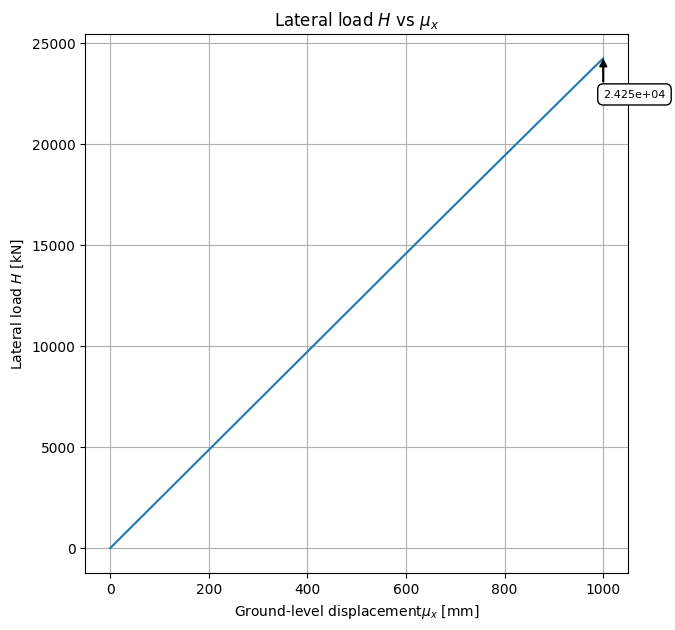

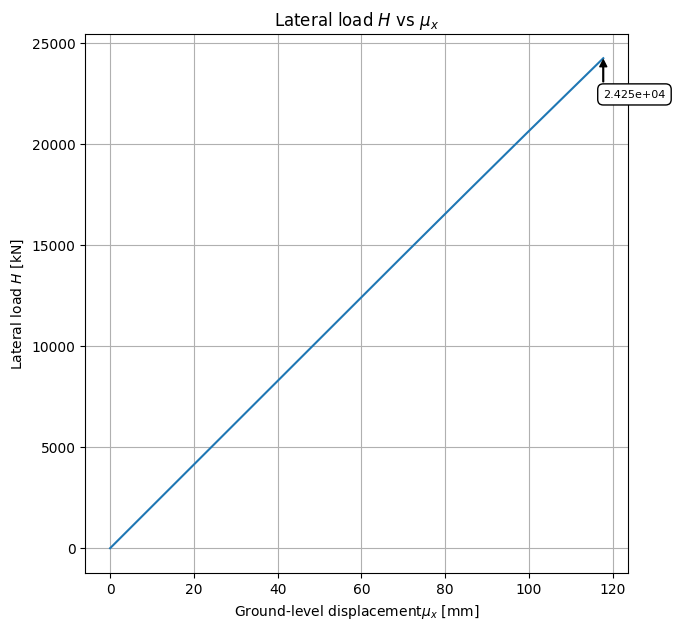

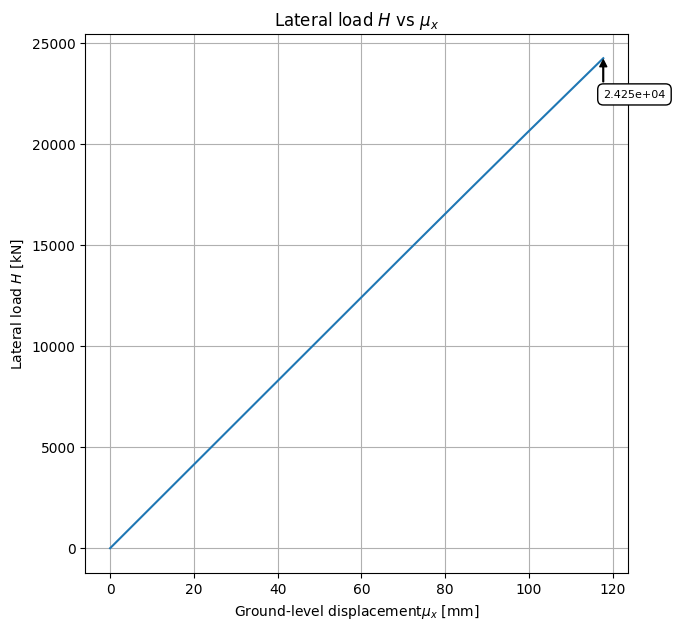

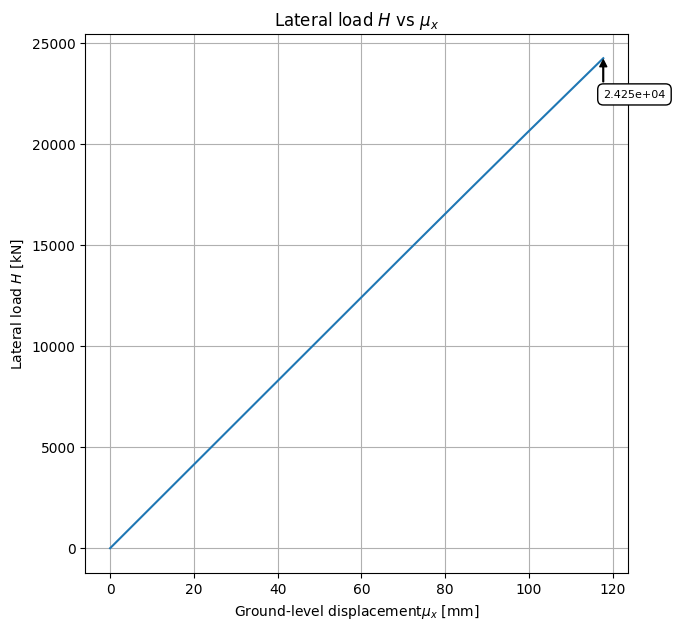

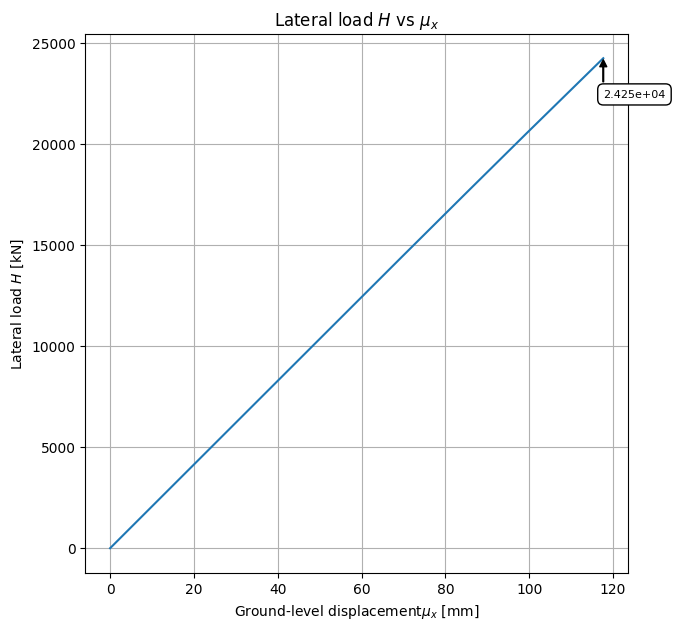

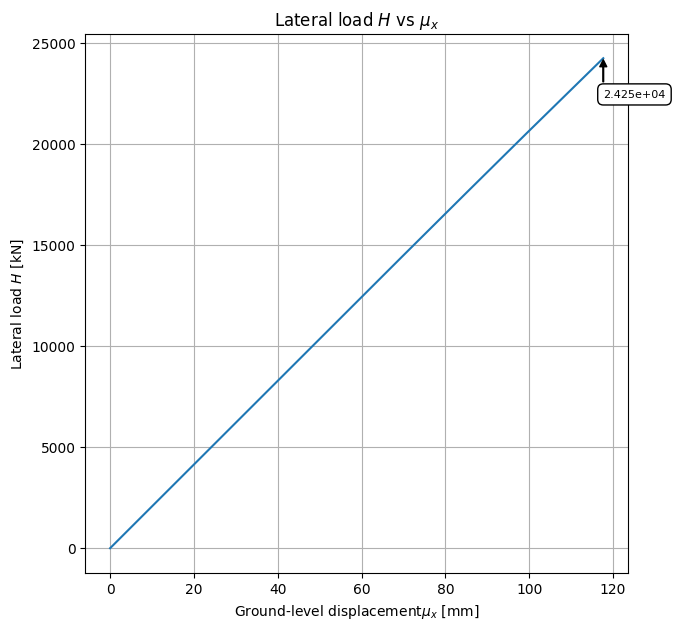

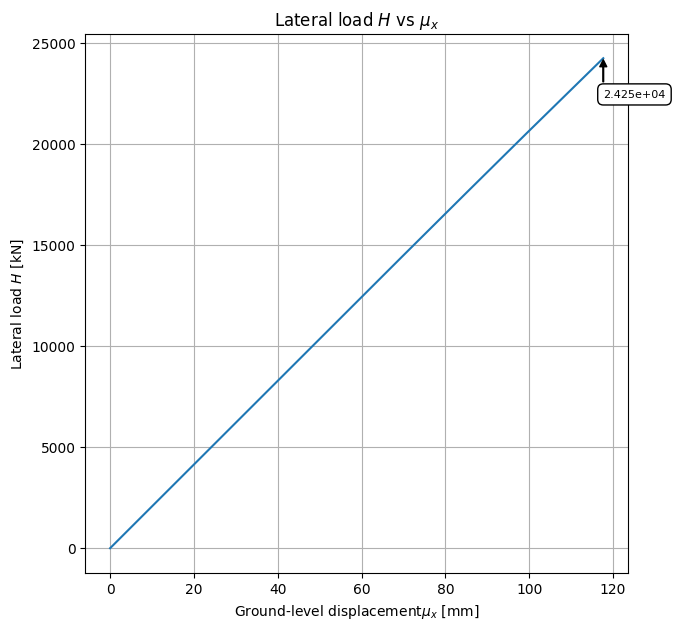

In [ ]:
params = initialize_parameters(
    order = 1, #order of approximation functions
    case_name = "pile",
    custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_1.cub", 
    base = "hex",
    soil_model=cm.PropertyTypeEnum.vM,
    
    final_time = 1, # [s]
    time_step = 1 / 200, # [s]
    options_file = "/mofem_install/jupyter/thomas/mfront_example_test/param_file.petsc",
    
    save_gauss = 1,
    
    FEA_completed=True,
    days_since_epoch=104,
    sim_otd=1,
    
    # prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0),
    prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0),
    
    points_of_interest = [
        cm.Point(x=1,y=0,z=10),
        cm.Point(x=-1,y=0,z=0),
        cm.Point(x=1,y=0,z=0),
    ],
    line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),),
) # 2. Simulation Parameters
params = setup.setup(params) # 3. Log paths and meta
if params.FEA_completed:
    # postprocess_extract(params)
    postprocess_calculate(params)
    postprocess_plot_new(params)
    # core.export_to_vtk(params)
    # postprocessing(params) # 7. Extract data from .vtk files 
    # plot_all_and_auxiliary_saves(params) # 8. Plotting
    pass
else:
    core.generate_mesh(params) # 4. Generate the mesh
    core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
    core.export_to_vtk(params)
    postprocessing(params) # 7. Extract data from .vtk files 
    plot_all_and_auxiliary_saves(params) # 8. Plotting
    

In [32]:
# Example
point_coords = np.array([-1 , 0, 0])
mesh = pv.read('/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_104_sim_1_20241129_010700_vM/vtks/out_mi_200.vtk')
components = ['x', 'y', 'z']
# # Extract data from all points that match the given coordinates
all_point_ids = np.where(np.all(mesh.points == point_coords, axis=1))[0]
fields = ["STRAIN", "STRESS", "DISPLACEMENT"]
if len(all_point_ids) == 0:    
    print(f"No points found at coordinates {point_coords}")
else:    
    for field_name in fields:
        for pid in all_point_ids: 
            point_data = mesh.point_data[field_name][pid]        
            print(f"Data at point {point_coords} (ID: {pid}) for field '{field_name}': {point_data}")

Data at point [-1  0  0] (ID: 61591) for field 'STRAIN': [ 2.23505256e-03 -4.22318760e-05 -1.84781730e-03 -4.22318760e-05
  1.61105547e-03  7.97283538e-04 -1.84781730e-03  7.97283538e-04
 -5.71830491e-03]
Data at point [-1  0  0] (ID: 61803) for field 'STRAIN': [ 2.23505256e-03 -4.22318760e-05  4.59348117e-03 -4.22318760e-05
  1.61105547e-03  7.97283538e-04  4.59348117e-03  7.97283538e-04
 -1.74314173e-02]
Data at point [-1  0  0] (ID: 71015) for field 'STRAIN': [-0.07076102 -0.00358136 -0.36001824 -0.00358136  0.00161151 -0.03455765
 -0.36001824 -0.03455765 -0.01743142]
Data at point [-1  0  0] (ID: 61591) for field 'STRESS': [  127.8315225     -6.49721169  -284.2795847     -6.49721169
    31.83196997   122.6590059   -284.2795847    122.6590059
 -1095.761934  ]
Data at point [-1  0  0] (ID: 61803) for field 'STRESS': [-1223.681446      -6.49721169   706.6894115     -6.49721169
 -1319.680999     122.6590059    706.6894115    122.6590059
 -4249.292194  ]
Data at point [-1  0  0] (ID: 71

In [33]:
for point in params.points_of_interest:
    csv_files = [f for f in os.listdir(point.point_dir(params)) if f.startswith("point_data_") and f.endswith(".csv")]
    
    for csv_file in csv_files:
        pid = int(csv_file.split('_')[2].split('.')[0])
        df = pd.read_csv(point.point_dir(params) / csv_file)
        
        sig_1 = np.array(df['SIG_1'])
        sig_2 = np.array(df['SIG_2'])
        sig_3 = np.array(df['SIG_3'])

        x_1 = sig_1
        y_1 = sig_2
        z_1 = sig_3

        # Convert lists to JavaScript arrays
        x_1_js = ', '.join(map(str, x_1))
        y_1_js = ', '.join(map(str, y_1))
        z_1_js = ', '.join(map(str, z_1))
        if params.soil_model == cm.PropertyTypeEnum.vM:
            sig_y = 10
            H = 0
            interacative_html_js = f"""
                <!DOCTYPE html>
                <html lang="en">
                <head>
                    <meta charset="UTF-8">
                    <meta name="viewport" content="width=device-width, initial-scale=1.0">
                    <title>Desmos Calculator Debug</title>
                    <script src="https://www.desmos.com/api/v1.11/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
                </head>
                <body>
                <div id="calculator" style="width: 1200px; height: 600px;"></div>
                <script>
                    var elt = document.getElementById('calculator');
                    var calculator = Desmos.Calculator3D(elt);
                    calculator.setExpression({{id:'exp1', latex: 'I = x + y + z'}});
                    calculator.setExpression({{id:'exp2', latex: 'p = I / 3'}});
                    calculator.setExpression({{id:'exp3', latex: 'J_2= \\\\frac{{1}}{{6}} \\\\cdot ((x-y)^2 + (y-z)^2 + (z-x)^2) '}});
                    calculator.setExpression({{id:'exp4', latex: 'q = \\\\sqrt{{3 \\\\cdot J_2}}'}});
                    calculator.setExpression({{id:'exp5', latex: 's_{{0}}={sig_y}'}});
                    calculator.setExpression({{id:'exp6', latex: 'H = {H}'}});

                    calculator.setExpression({{id:'exp7', 
                    latex: '0 = q - s_{{0}}',
                    color: Desmos.Colors.RED,
                    }});

                    calculator.setExpression({{
                        type: 'table',
                        columns: [
                            {{
                                latex: 'x_1',
                                values: [{x_1_js}]
                            }},
                            {{
                                latex: 'y_1',
                                values: [{y_1_js}],
                            }},
                            {{
                                latex: 'z_1',
                                values: [{z_1_js}],
                            }},
                        ]
                    }});

                    calculator.setExpression({{id:'exp9', 
                    latex: '(x_{{1}},y_{{1}},z_{{1}})',
                    color: Desmos.Colors.BLUE,
                    }});
                    
                    
                    function downloadScreenshot() {{
                        var screenshot = calculator.screenshot();
                        var link = document.createElement('a');
                        link.href = screenshot;
                        link.download = 'screenshot.png';
                        document.body.appendChild(link);
                        link.click();
                        document.body.removeChild(link);
                    }}
                    
                </script>
                <h2>Interactive Content</h2>
                <button onclick="downloadScreenshot()">Click me to download screenshot!</button>
                </body>
                """
        elif params.soil_model == cm.PropertyTypeEnum.dpHYPER or params.soil_model == cm.PropertyTypeEnum.dp:
            c = 10
            # a = 1e-16
            phi = 15 * math.pi / 180
            
            # Combine HTML and JavaScript to create interactive content within the notebook
            interacative_html_js = f"""
            <!DOCTYPE html>
            <html lang="en">
            <head>
                <meta charset="UTF-8">
                <meta name="viewport" content="width=device-width, initial-scale=1.0">
                <title>Desmos Calculator Debug</title>
                <script src="https://www.desmos.com/api/v1.11/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
            </head>
            <body>
            <div id="calculator" style="width: 1200px; height: 600px;"></div>
            <script>
                var elt = document.getElementById('calculator');
                var calculator = Desmos.Calculator3D(elt);
                calculator.setExpression({{id:'exp1', latex: 'I = x + y + z'}});
                calculator.setExpression({{id:'exp2', latex: 'p = I / 3'}});
                calculator.setExpression({{id:'exp3', latex: 'J_2= \\\\frac{{1}}{{6}} \\\\cdot ((x-y)^2 + (y-z)^2 + (z-x)^2) '}});
                calculator.setExpression({{id:'exp4', latex: 'q = \\\\sqrt{{3 \\\\cdot J_2}}'}});
                calculator.setExpression({{id:'exp5', latex: 'p_{{hi}} = {phi}'}});
                calculator.setExpression({{id:'exp6', latex: 'M_{{JP}} = \\\\frac{{2\\\\sqrt{{3}}\\\\sin p_{{hi}}}}{{3-\\\\sin p_{{hi}}}}'}});
                calculator.setExpression({{id:'exp7', latex: 'a = 10^{{-12}}'}});
                calculator.setExpression({{id:'exp8', latex: 'c = {c}'}});

                calculator.setExpression({{id:'exp9', 
                latex: '0 = + M_{{JP}} p + \\\\sqrt{{a^{{2}} M_{{JP}}^{{2}} + \\\\frac{{q}}{{\\\\sqrt{{3}}}}^{{2}}}} - M_{{JP}} \\\\cdot \\\\frac{{c}}{{\\\\tan p_{{hi}}}}',
                color: Desmos.Colors.RED,
                }});

                calculator.setExpression({{
                    type: 'table',
                    columns: [
                        {{
                            latex: 'x_1',
                            values: [{x_1_js}]
                        }},
                        {{
                            latex: 'y_1',
                            values: [{y_1_js}],
                        }},
                        {{
                            latex: 'z_1',
                            values: [{z_1_js}],
                        }},
                    ]
                }});

                calculator.setExpression({{id:'exp11', 
                latex: '(x_{{1}},y_{{1}},z_{{1}})',
                color: Desmos.Colors.BLUE,
                }});
                
                
                function downloadScreenshot() {{
                    var screenshot = calculator.screenshot();
                    var link = document.createElement('a');
                    link.href = screenshot;
                    link.download = 'screenshot.png';
                    document.body.appendChild(link);
                    link.click();
                    document.body.removeChild(link);
                }}
                
            </script>
            <h2>Interactive Content</h2>
            <button onclick="downloadScreenshot()">Click me to download screenshot!</button>
            </body>
            """
        Html_file= open(f"{point.point_dir(params)}/Desmos3D_{pid}.html","w")
        Html_file.write(interacative_html_js)
        Html_file.close()
        

In [34]:
# from IPython.display import HTML

# for point in params.points_of_interest:
    
#     graph_dir = point.graph_dir(params)
#     df = pd.read_csv(point.point_against_time_csv_filepath(params))
#     if params.save_gauss == 1:
#         disp_x = np.array(df['avg(U (0))'])
#         disp_y = np.array(df['avg(U (1))'])
#         disp_z = np.array(df['avg(U (2))'])
        
#         e_xx = np.array(df['avg(Strain (0))'])
#         e_xy = np.array(df['avg(Strain (1))'])
#         e_xz = np.array(df['avg(Strain (2))'])
#         e_yy = np.array(df['avg(Strain (4))'])
#         e_yz = np.array(df['avg(Strain (5))'])
#         e_zz = np.array(df['avg(Strain (8))'])
            
#         sig_xx = np.array(df['avg(Stress (0))'])
#         sig_xy = np.array(df['avg(Stress (1))'])
#         sig_xz = np.array(df['avg(Stress (2))'])
#         sig_yy = np.array(df['avg(Stress (4))'])
#         sig_yz = np.array(df['avg(Stress (5))'])
#         sig_zz = np.array(df['avg(Stress (8))'])
        
#     elif params.save_gauss == 0:
#         disp_x = np.array(df['avg(DISPLACEMENT (0))'])
#         disp_y = np.array(df['avg(DISPLACEMENT (1))'])
#         disp_z = np.array(df['avg(DISPLACEMENT (2))'])
        
#         e_xx = np.array(df['avg(STRAIN (0))'])
#         e_xy = np.array(df['avg(STRAIN (1))'])
#         e_xz = np.array(df['avg(STRAIN (2))'])
#         e_yy = np.array(df['avg(STRAIN (4))'])
#         e_yz = np.array(df['avg(STRAIN (5))'])
#         e_zz = np.array(df['avg(STRAIN (8))'])
            
#         sig_xx = np.array(df['avg(STRESS (0))'])
#         sig_xy = np.array(df['avg(STRESS (1))'])
#         sig_xz = np.array(df['avg(STRESS (2))'])
#         sig_yy = np.array(df['avg(STRESS (4))'])
#         sig_yz = np.array(df['avg(STRESS (5))'])
#         sig_zz = np.array(df['avg(STRESS (8))'])
        
#     sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)

#     x_1 = sig_1
#     y_1 = sig_2
#     z_1 = sig_3

#     # Convert lists to JavaScript arrays
#     x_1_js = ', '.join(map(str, x_1))
#     y_1_js = ', '.join(map(str, y_1))
#     z_1_js = ', '.join(map(str, z_1))
#     if params.soil_model == cm.PropertyTypeEnum.vM:
#         sig_y = 10
#         H = 0
#         interacative_html_js = f"""
#             <!DOCTYPE html>
#             <html lang="en">
#             <head>
#                 <meta charset="UTF-8">
#                 <meta name="viewport" content="width=device-width, initial-scale=1.0">
#                 <title>Desmos Calculator Debug</title>
#                 <script src="https://www.desmos.com/api/v1.11/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
#             </head>
#             <body>
#             <div id="calculator" style="width: 1200px; height: 600px;"></div>
#             <script>
#                 var elt = document.getElementById('calculator');
#                 var calculator = Desmos.Calculator3D(elt);
#                 calculator.setExpression({{id:'exp1', latex: 'I = x + y + z'}});
#                 calculator.setExpression({{id:'exp2', latex: 'p = I / 3'}});
#                 calculator.setExpression({{id:'exp3', latex: 'J_2= \\\\frac{{1}}{{6}} \\\\cdot ((x-y)^2 + (y-z)^2 + (z-x)^2) '}});
#                 calculator.setExpression({{id:'exp4', latex: 'q = \\\\sqrt{{3 \\\\cdot J_2}}'}});
#                 calculator.setExpression({{id:'exp5', latex: 's_{{0}}={sig_y}'}});
#                 calculator.setExpression({{id:'exp6', latex: 'H = {H}'}});

#                 calculator.setExpression({{id:'exp7', 
#                 latex: '0 = q - s_{{0}}',
#                 color: Desmos.Colors.RED,
#                 }});

#                 calculator.setExpression({{
#                     type: 'table',
#                     columns: [
#                         {{
#                             latex: 'x_1',
#                             values: [{x_1_js}]
#                         }},
#                         {{
#                             latex: 'y_1',
#                             values: [{y_1_js}],
#                         }},
#                         {{
#                             latex: 'z_1',
#                             values: [{z_1_js}],
#                         }},
#                     ]
#                 }});

#                 calculator.setExpression({{id:'exp9', 
#                 latex: '(x_{{1}},y_{{1}},z_{{1}})',
#                 color: Desmos.Colors.BLUE,
#                 }});
                
                
#                 function downloadScreenshot() {{
#                     var screenshot = calculator.screenshot();
#                     var link = document.createElement('a');
#                     link.href = screenshot;
#                     link.download = 'screenshot.png';
#                     document.body.appendChild(link);
#                     link.click();
#                     document.body.removeChild(link);
#                 }}
                
#             </script>
#             <h2>Interactive Content</h2>
#             <button onclick="downloadScreenshot()">Click me to download screenshot!</button>
#             </body>
#             """
#     elif params.soil_model == cm.PropertyTypeEnum.dpHYPER or params.soil_model == cm.PropertyTypeEnum.dp:
#         c = 10
#         # a = 1e-16
#         phi = 15 * math.pi / 180
        
#         # Combine HTML and JavaScript to create interactive content within the notebook
#         interacative_html_js = f"""
#         <!DOCTYPE html>
#         <html lang="en">
#         <head>
#             <meta charset="UTF-8">
#             <meta name="viewport" content="width=device-width, initial-scale=1.0">
#             <title>Desmos Calculator Debug</title>
#             <script src="https://www.desmos.com/api/v1.11/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
#         </head>
#         <body>
#         <div id="calculator" style="width: 1200px; height: 600px;"></div>
#         <script>
#             var elt = document.getElementById('calculator');
#             var calculator = Desmos.Calculator3D(elt);
#             calculator.setExpression({{id:'exp1', latex: 'I = x + y + z'}});
#             calculator.setExpression({{id:'exp2', latex: 'p = I / 3'}});
#             calculator.setExpression({{id:'exp3', latex: 'J_2= \\\\frac{{1}}{{6}} \\\\cdot ((x-y)^2 + (y-z)^2 + (z-x)^2) '}});
#             calculator.setExpression({{id:'exp4', latex: 'q = \\\\sqrt{{3 \\\\cdot J_2}}'}});
#             calculator.setExpression({{id:'exp5', latex: 'p_{{hi}} = {phi}'}});
#             calculator.setExpression({{id:'exp6', latex: 'M_{{JP}} = \\\\frac{{2\\\\sqrt{{3}}\\\\sin p_{{hi}}}}{{3-\\\\sin p_{{hi}}}}'}});
#             calculator.setExpression({{id:'exp7', latex: 'a = 10^{{-12}}'}});
#             calculator.setExpression({{id:'exp8', latex: 'c = {c}'}});

#             calculator.setExpression({{id:'exp9', 
#             latex: '0 = + M_{{JP}} p + \\\\sqrt{{a^{{2}} M_{{JP}}^{{2}} + \\\\frac{{q}}{{\\\\sqrt{{3}}}}^{{2}}}} - M_{{JP}} \\\\cdot \\\\frac{{c}}{{\\\\tan p_{{hi}}}}',
#             color: Desmos.Colors.RED,
#             }});

#             calculator.setExpression({{
#                 type: 'table',
#                 columns: [
#                     {{
#                         latex: 'x_1',
#                         values: [{x_1_js}]
#                     }},
#                     {{
#                         latex: 'y_1',
#                         values: [{y_1_js}],
#                     }},
#                     {{
#                         latex: 'z_1',
#                         values: [{z_1_js}],
#                     }},
#                 ]
#             }});

#             calculator.setExpression({{id:'exp11', 
#             latex: '(x_{{1}},y_{{1}},z_{{1}})',
#             color: Desmos.Colors.BLUE,
#             }});
            
            
#             function downloadScreenshot() {{
#                 var screenshot = calculator.screenshot();
#                 var link = document.createElement('a');
#                 link.href = screenshot;
#                 link.download = 'screenshot.png';
#                 document.body.appendChild(link);
#                 link.click();
#                 document.body.removeChild(link);
#             }}
            
#         </script>
#         <h2>Interactive Content</h2>
#         <button onclick="downloadScreenshot()">Click me to download screenshot!</button>
#         </body>
#         """
#     Html_file= open(f"{graph_dir}/Desmos3D.html","w")
#     Html_file.write(interacative_html_js)
#     Html_file.close()